Reconstruct a single, upsampled high resolution image from a series of low resolution images using Fourier ptychography.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os
from PIL import Image, ImageOps
import numpy as np
from scipy.fft import fft2, ifft2
import time
from IPython.display import clear_output
# import gpiod


In [5]:
# Turn on fan

# Set the chip and line (pin number on the chip)
chip_name = "gpiochip4"
line_offset = 45  # This corresponds to GPIO pin 45

# Open the GPIO chip
chip = gpiod.Chip(chip_name)
line = chip.get_line(line_offset)

# Request the line as an output with a value of 0 (low)
line.request(consumer="my_gpio_control", type=gpiod.LINE_REQ_DIR_OUT)

# Set the GPIO pin to low (0) or high (1)
line.set_value(0)  # 0 for LOW, 1 for HIGH

# Release the line when done
line.release()


In [3]:
# Functions

# Starting at 7,7, generate coordinates to turn on LEDs in a spiral pattern, moving right up left down right up left down....
# 0,0 is bottom left LED when rotation is 135 degrees
def LED_spiral(n):
    # Input: n; gridsize to generate coordinates for
    # Returns: x_coords, y_coords; arrays for LED coordinates 
    
    # Initialize the arrays to store the x and y coordinates
    x_coords = np.zeros(n**2, dtype=int)
    y_coords = np.zeros(n**2, dtype=int)
    
    # Starting point
    x, y = 7, 7
    x_coords[0], y_coords[0] = x, y
    
    step_size = 1  # How far to move in each direction before changing direction
    index = 1  # Tracks the number of coordinates generated so far
    
    while index < n**2:
        # Move right
        for _ in range(step_size):
            if index >= n**2:
                break
            x += 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        # Move up
        for _ in range(step_size):
            if index >= n**2:
                break
            y += 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        step_size += 1  # Increase step size after moving right and up
        
        # Move left
        for _ in range(step_size):
            if index >= n**2:
                break
            x -= 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        # Move down
        for _ in range(step_size):
            if index >= n**2:
                break
            y -= 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        step_size += 1  # Increase step size after moving left and down
    
    return x_coords, y_coords

# Find a suitable size of the object
def calculate_object_size(img_size, grid_size, LED2SAMPLE, LED_P, NA, WLENGTH, PIX_SIZE):
    sampling_size = 1/(img_size*PIX_SIZE) # Sampling size in x
    r = np.sqrt(2*(grid_size*LED_P*0.5)**2) # Max radius of LED from center
    led_na = r/(np.sqrt(r**2+LED2SAMPLE**2)) # Max NA of LED
    max_freq = led_na/WLENGTH + NA/WLENGTH # Maximum spacial frequency in x
    
    return np.ceil(2*np.round(2*max_freq/sampling_size)/img_size)*img_size # obj_size will be a multiple of img_size

# Find the LED positions in Fourier domain
def calculate_fourier_positions(x, y, LED2SAMPLE, WLENGTH, PIX_SIZE, img_size):
    sampling_size = 1/(img_size*PIX_SIZE) # Sampling size in x
    kx = np.zeros(len(x))
    ky = np.zeros(len(x))
    for i in range(len(x)):
        sin_thetax = x[i]/(np.sqrt(x[i]**2 + LED2SAMPLE**2))
        kx[i] = sin_thetax/(WLENGTH*sampling_size)
        
        sin_thetay = y[i]/(np.sqrt(y[i]**2 + LED2SAMPLE**2))
        ky[i] = sin_thetay/(WLENGTH*sampling_size)
    
    return kx,ky

# Shifted fourier transform
def FT(x):
    return np.fft.fftshift(fft2(np.fft.ifftshift(x)))

# Shifted inverse fourier transform
def IFT(x):
    return np.fft.fftshift(ifft2(np.fft.ifftshift(x)))

# Plotting for visualising reconstruction (used in reconstruct function)
def plot(axes,fig, obj,x_start,y_start,img_size,obj_center,pupil,kx,ky,i,iter):
    # Clear previous plots
    for ax in axes:
        ax.cla()  # Clear the current axes
      
    axes[0].imshow(np.log(np.abs(obj) + 1), cmap='gray') # Show with log scale
    axes[0].set_title(f'Spectrum of object: image {i+1}, iteration {iter+1} ')
    square = patches.Rectangle((x_start, y_start), img_size, img_size, linewidth=0.5, edgecolor='red', facecolor='none')
    axes[0].add_patch(square)
    circle = patches.Circle((obj_center+kx[i],obj_center-ky[i]), radius=pupil_radius,linewidth =0.5, edgecolor='red',facecolor='none')
    axes[0].add_patch(circle)

    axes[1].imshow(np.abs(IFT(obj)), cmap='gray')
    axes[1].set_title('Currently reconstructed object')
    
    axes[2].imshow(np.angle(pupil),cmap='gray')
    axes[2].set_title('Current pupil phase')
    
    axes[3].imshow(np.abs(pupil),cmap='gray')
    axes[3].set_title('Current pupil magnitude')
    
    # Update the figure
    clear_output(wait=True)  # Clear the output before displaying the new figure 
    display(fig)  # Display the updated figure
    plt.pause(0.1)  # Pause to allow the figure to update if needed

# Reconstruct object and pupil function using Quasi Newton algorithm
def reconstruct(images, kx, ky, obj, pupil, options):
    # Inputs: 
    # images; low res image array data, in order taken
    # kx,ky; location of LEDs in Fourier domain, in order of images taken
    # obj; initial estimate for object in frequency domain
    # pupil; initial pupil function
    # options; alpha, beta (regularisation), max_iter, plotting
    
    # Returns: 
    # rec_obj; recovered object
    # rec_pupil; recovered pupil function
    
    # Unpack options
    alpha = options['alpha']
    beta = options['beta']
    max_iter = options['max_iter']
    plot_mode = options['plot_mode'] # 0, off; 1, plot every image; 2, plot every iteration
    
    # Other parameters
    img_size = images.shape[0] # Square, same size as pupil function
    img_center = img_size // 2
    num_images = images.shape[2]
    obj_size = obj.shape[0] # Square
    obj_center = obj_size // 2 # Center of object (used for inserting spectra in correct place)
    pupil_binary = np.copy(pupil) # Original pupil function (binary mask)
    pupil = pupil.astype('complex64') # Pupil function for updating needs to be complex 
        
    # If plotting, create axis and figure here to save resources
    if plot_mode != 0:
        global pupil_radius 
        fig, axes = plt.subplots(1, 4, figsize=(15,15))

    for iter in range(max_iter):
        for i in range(num_images): # For each image in data set   
            x_start = int(obj_center + kx[i] - img_size//2) # For cropping object spectrum (see plots)
            y_start = int(obj_center - ky[i] - img_size//2)  
            
            # Define variables for object and pupil updating 
              
            # The relevant part of object spectrum to update
            object_update = obj[y_start:y_start+img_size, x_start:x_start+img_size]
             
            # Measured image amplitude
            img = np.sqrt(images[:,:,i])
            
            # Estimated image amplitude from object (complex)
            img_est = IFT(object_update)
            
            # The update image (in Fourier domain) is composed of the magnitude of the measured image, the phase of the estimated image
            # and also the spectrum of the estimated image is subtracted
            update_image = FT(img*np.exp(1j*np.angle(img_est))) - FT(img_est)
            
            # Object update
            numerator = np.abs(pupil) * np.conj(pupil) * update_image
            denominator = np.max(np.abs(pupil)) * (np.abs(pupil)**2 + alpha)
            object_update = numerator / denominator   
            obj[y_start:y_start+img_size, x_start:x_start+img_size] += 0.5*object_update # Add to main spectrum
               
            # Pupil update
            numerator = np.abs(object_update) * np.conj(object_update) * update_image * pupil_binary
            denominator = np.max(obj) * (np.abs(object_update)**2 + beta)
            pupil_update = numerator / denominator
            pupil += 0.1*pupil_update
      
            # print(np.mean(np.abs(object_update)))  
 
            # Plot every image
            if plot_mode == 1:
                plot(axes,fig, obj,x_start,y_start,img_size,obj_center,pupil,kx,ky,i,iter)
        
        # Plot every iteration
        if plot_mode == 2:
            plot(axes,fig, obj,x_start,y_start,img_size,obj_center,pupil,kx,ky,i,iter)

    return IFT(obj),pupil


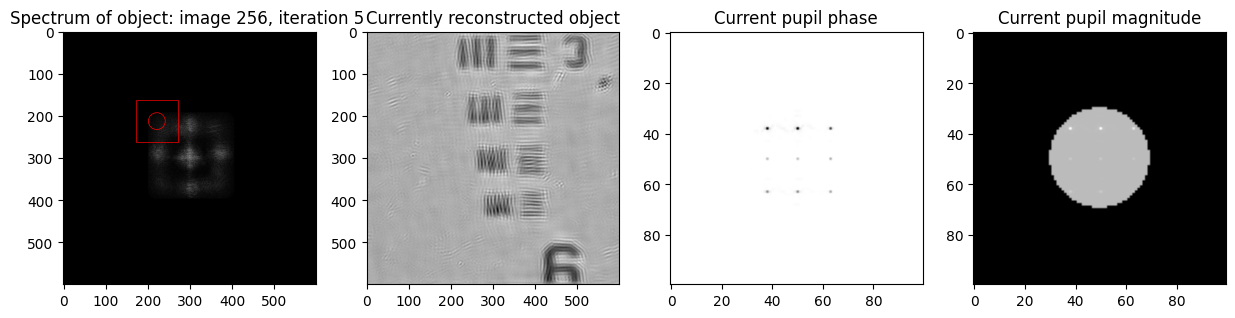

In [78]:
## Main FPM reconstruction. Set up for square, grayscale images

# Load image data into an array
data_path = 'data/usaf_new_2'
grid_size = 16 # 1 -> 16, determines how many images to reconstruct with, beyond 12x12 grid images are mostly useless
img_size = 100 # Size of low res image (original or crop)
crop_x = 160 # From left
crop_y = 100 # From top

num_images = grid_size**2
images = np.zeros((img_size,img_size,num_images)) # Initialise array for storing images
brightfield = np.array(Image.open(os.path.join(data_path,'brightfield.png')))/256 # Brightfield image for reference
brightfield = brightfield[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop

for i in range(num_images): # ~ 2s to load all 256 images into array
    filename = os.path.join(data_path, f'image_{i}.png') # Construct path
    img = np.array(Image.open(filename))/256 # Open image and convert to array, with data range 0-1
    img = img[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop
    images[:,:,i] = img

# Experiment parameters
x_coords, y_coords = LED_spiral(grid_size) # LED coordinates in sequence
LED2SAMPLE = 54 # Distance from LED array to the sample, 54mm (larger distance leads to closer overlapping Fourier circles, optimal 40-60%)
LED_P = 3.3 # LED pitch, mm
N_GLASS = 1.52 # Glass refractive index
NA = 0.1 # Objective numerical apature
PIX_SIZE = 1100e-9 # Pixel size on object plane, m, 1.09um for 3D printed microscope (directly measured), 862.5nm for old data
WLENGTH = 550e-9 # Central wavelength of LED light, m

# Derived variables
F_CUTOFF = 2*NA/WLENGTH # Highest spatial frequency we can resolve in the optical system due to diffraction, lp/m
F_SAMPLING = 1/PIX_SIZE # Sampling frequency (based on sensor pixel size and magnification), lp/m
x_abs = (x_coords - x_coords[0])*LED_P # x distances of LEDs from center LED
y_abs = (y_coords - y_coords[0])*LED_P # y distances of LEDs from center LED

# Size of object image (for given parameters upsampling is between 2 and 5 depending on grid_size)
# Can do seperately x and y if image is not square
obj_size = calculate_object_size(img_size, grid_size, LED2SAMPLE, LED_P, NA, WLENGTH, PIX_SIZE)

# Locations of LEDs in Fourier domain
kx,ky = calculate_fourier_positions(x_abs, y_abs, LED2SAMPLE, WLENGTH, PIX_SIZE, img_size)

# Initial pupil function (binary mask)
# Nyquist sampling criterion: sampling_ratio >2 -> oversampling, sampling_ratio <2 -> undersampling (aliasing may occur)
sampling_ratio = F_SAMPLING / F_CUTOFF 
# x,y is our normalised frequency domain for the images, cutoff frequency = 1 (both x and y)
x,y = np.meshgrid(np.linspace(-sampling_ratio,sampling_ratio,img_size), np.linspace(-sampling_ratio,sampling_ratio,img_size))
theta,r = np.arctan2(y,x), np.sqrt(x**2 + y**2) # Polar coordinates
pupil_radius = (1/sampling_ratio) * (img_size/2) # For plotting and diagnostics
pupil = r<1 # Binary mask for frequencies below cutoff frequency (higher frequencies cannot be resolved due to diffraction)

# Initial object estimate (using first image)
img = np.sqrt(images[:,:,0]) # Amplitude of central image
# img = np.sqrt(brightfield) # Could alternatively use brightfield if we have it
F_img = FT(img) # Fourier transformed image (with shift)
F_img = F_img * pupil # Apply pupil function
pad_width = int((obj_size - img_size) / 2) # Padding to make correct size
obj = np.pad(F_img,pad_width,'constant',constant_values=0) # Initial object in frequency domain

# Set parameters for reconstruction algorithm
options = {
    'max_iter': 5, # Number of iterations
    'alpha': 10, # Regularisation parameter, <10, does make a difference
    'beta': 100, # Regularisation parameter, >0, not important
    'plot_mode': 2, # 0, off; 1, plot every image; 2, plot every iteration
}


rec_obj, rec_pupil = reconstruct(images, kx, ky, obj, pupil, options)

Plotting and save results

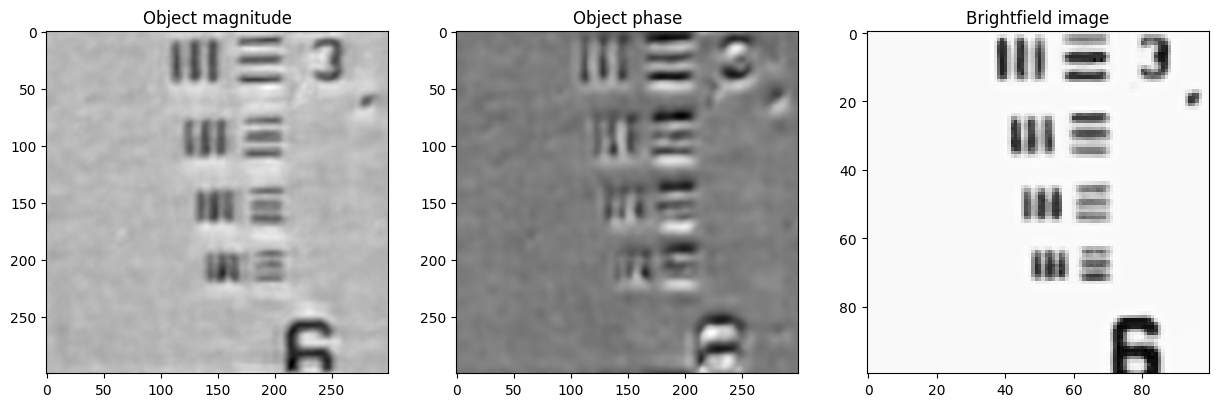

In [62]:
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15,15))

obj_mag = np.abs(rec_obj) # Magnitude
obj_arg = np.angle(rec_obj) # Phase

axes[0].imshow(obj_mag,cmap='gray')
axes[0].set_title('Object magnitude')
axes[1].imshow(obj_arg, cmap='gray')
axes[1].set_title('Object phase')
axes[2].imshow(brightfield, cmap='gray')
axes[2].set_title('Brightfield image')

# Save results
obj_mag = (obj_mag / obj_mag.max() * 255).astype(np.uint8)
obj_mag = Image.fromarray(obj_mag)
obj_mag.save('results/magnitude.png')

obj_arg = (obj_arg / obj_arg.max() * 255).astype(np.uint8)
obj_arg = Image.fromarray(obj_arg)
obj_arg.save('results/phase.png')

bf = Image.open(os.path.join(data_path,'brightfield.png'))
bf.save('results/brightfield.png')




In [ ]:
# Show LED sequence and positions in spatial frequency domain
plt.plot(kx,ky,'-x') 
plt.plot(x_abs,y_abs)
plt.title('LED positions in real space and k space')

Inspect images and their Fourier transforms

Text(0, 0.5, 'Dynamic range')

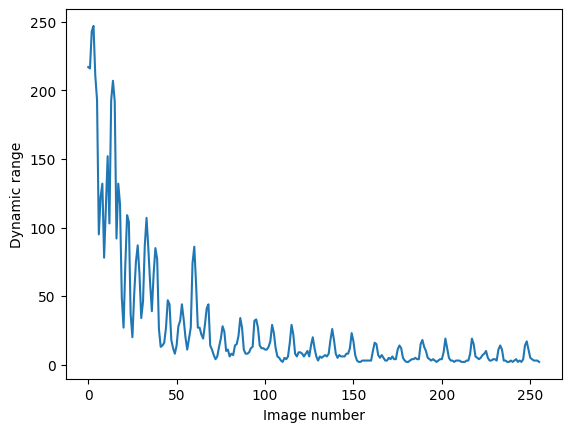

In [87]:
# img = images[:,:,101]

# fig, axes = plt.subplots(1, 2, figsize=(15,15))

# axes[0].imshow(np.log(np.abs(FT(img)) + 1), cmap='gray') # Show FT with log scale
# axes[1].imshow(img/np.max(img), cmap='gray') # Normalised image
# print(np.max(img)*256, np.min(img)*256) # Dynamic range of image

img_ranges = np.zeros((2,num_images))
for i in range(num_images):
    img = images[:,:,i]
    max = np.max(img)*256
    min = np.min(img)*256
    img_ranges[0,i] = max-min
    img_ranges[1,i] = i

plt.plot(img_ranges[1,:],img_ranges[0,:])
plt.xlabel('Image number')
plt.ylabel('Dynamic range')